In [ ]:
from PIL import Image
import numpy as np


class ImageCropper:
    def __init__(self, image_name):
        self.image = np.asarray (Image.open(image_name))

    def get_cropped_squares(self, original_square_size, offset=0):
        height = len(self.image)
        width = len(self.image[0])
        square_size = original_square_size + offset

        if (offset != 0):
          upper_left = np.empty((square_size, square_size, 3))
          upper_right = np.empty((square_size, square_size, 3))
          lower_left = np.empty((square_size, square_size, 3))
          lower_right = np.empty((square_size, square_size, 3))

          upper = np.empty((square_size, width, 3))
          lower = np.empty((square_size, width, 3))
          left = np.empty((height, square_size, 3))
          right = np.empty((height, square_size, 3))
        else:
          upper_left = np.empty((square_size, square_size))
          upper_right = np.empty((square_size, square_size))
          lower_left = np.empty((square_size, square_size))
          lower_right = np.empty((square_size, square_size))

          upper = np.empty((square_size, width))
          lower = np.empty((square_size, width))
          left = np.empty((height, square_size))
          right = np.empty((height, square_size))

        image = self.image

        upper_left[:, :] = image[0: square_size, 0: square_size]
        upper_left = np.flip(np.flip(upper_left, 0), 1)

        upper_right[:, :] = image[0: square_size, width - square_size: width]
        upper_right = np.flip(np.flip(upper_right, 0), 1)

        lower_left[:, :] = image[height - square_size: height, 0: square_size]
        lower_left = np.flip(np.flip(lower_left, 0), 1)

        lower_right[:, :] = image[height - square_size: height, width - square_size: width]
        lower_right = np.flip(np.flip(lower_right, 0), 1)

        upper[:, :] = image[0: square_size, 0: width]
        upper = np.flip(upper, 0)

        lower[:, :] = image[height - square_size: height, 0: width]
        lower = np.flip(lower, 0)

        left[:, :] = image[0: height, 0: square_size]
        left = np.flip(left, 1)

        right[:, :] = image[0: height, width - square_size: width]
        right = np.flip(right, 1)

        upper = np.hstack((upper_left, upper, upper_right))
        image = np.hstack((left, image, right))
        lower = np.hstack((lower_left, lower, lower_right))

        image = np.vstack((upper, image, lower))

        cropped_squares_small = []
        cropped_squares_big = []

        square_size -= offset
        #return image #!!!
        den1 = 1
        den2 = 1
        if height % square_size == 0:
            den1 = 0
        if width % square_size == 0:
            den2 = 0

        if offset == 0:
            for i in range(1, height // square_size + den1 + 1, 1):
                for j in range(1, width // square_size + den2 + 1, 1):
                    square = np.empty((square_size, square_size))
                    square[:, :] = image[i * square_size: (i + 1) * square_size, j * square_size: (j + 1) * square_size]
                    cropped_squares_small.append(square)

            return cropped_squares_small
        else:
            for i in range(1, height // square_size + den1 + 1, 1):
                for j in range(1, width // square_size + den2 + 1, 1):
                    square = np.empty((square_size + 2 * offset, square_size + 2 * offset, 3))
                    square[:, :] = image[i * square_size - offset: (i + 1) * square_size + offset, j * square_size - offset: (j + 1) * square_size + offset]
                    cropped_squares_big.append(square)
            return cropped_squares_big




    @staticmethod
    def save_cropped_images(path, cropped_images, ncounter=0, mask=''):
        counter = ncounter + 1
        for img in cropped_images:
            im = Image.fromarray(img.astype(np.uint8))
            im.save(path + f"/img{counter}" + mask + ".jpg")
            counter += 1
        return counter

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Error: CUDA is not available!')
else:
    print('CUDA is available!')
    DEVICE = torch.device("cuda")

CUDA is available!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!unzip -q /content/gdrive/MyDrive/tissue-segment.zip -d data/new_data2

In [ ]:
#!unzip -q /content/gdrive/MyDrive/cropped.zip -d /content/data/cropped_data/

In [ ]:
import os
os.mkdir("/content/data")
os.mkdir("/content/data/cropped_data")
!unzip -q /content/gdrive/MyDrive/cropped.zip -d /content/data/cropped_data/

In [ ]:
import pickle
import numpy as np
from skimage import io
import random
import torch
from tqdm import tqdm, tqdm_notebook
import PIL
from pathlib import Path

from torchvision import transforms
import torchvision.transforms.functional as TF
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
from matplotlib import pyplot as plt

In [ ]:
from traitlets.traitlets import Long
class TissueDataset(Dataset):
  
  def __init__(self, pic_ans_arr):

    super().__init__()
    self.pic_ans_arr = pic_ans_arr
    self.len_ = len(self.pic_ans_arr)

    
  def load_image(self, file):
    image = Image.open(os.path.join('/content/data/cropped_data/cropped', file))
    image.load()
    return image

  def __len__(self):
    return self.len_

  def __getitem__(self, index):
    x = self.load_image(self.pic_ans_arr[index][0])
    y = self.load_image(self.pic_ans_arr[index][1])
    convert_tensor = transforms.ToTensor()
    norm = transforms.Normalize(
          mean=[0.6, 0.6, 0.6],
          std=[0.229, 0.224, 0.225]
    )

    angle = random.choice([0, 90, 180, 270])
    x = TF.rotate(x, angle)
    y = TF.rotate(y, angle)

    y = convert_tensor(y)
    #print(torch.unique(y))
    if random.randint(0, 1) == 1:
      x = TF.hflip(x)
      y = TF.hflip(y)
    if random.randint(0, 1) == 1:
      x = TF.vflip(x)
      y = TF.vflip(y)
    x = TF.adjust_contrast(img = x, contrast_factor=1.5)
    x = TF.adjust_sharpness(img = x, sharpness_factor=1.5)
    #torchvision.transforms.Grayscale(num_output_channels=1)
    x = convert_tensor(x)
    x = norm(x)
    #x = x + torch.randn(x.size()) * torch.std(x) + torch.mean(x)

    y = torch.where(y > 0.5, 1.0, 0.0)
    if len(torch.unique(y)) == 2:
      clas_n = 2
    else:
      clas_n = 1
    return x, y, clas_n

DIR = Path('/content/data/new_data2')
train_files = sorted(DIR.rglob('*.jpg'))

In [ ]:
train_files_lb = [path.name for path in train_files]

pic_arr = []
ans_arr = []
for nm in train_files_lb:
  lenn = len(nm)
  if nm[lenn - 8: lenn - 4] == "mask":
    ans_arr.append(nm)
  else:
    pic_arr.append(nm)

pic_ans_arr = []
for i1 in range(len(ans_arr)):
  pic_ans_arr.append(tuple(list([pic_arr[i1], ans_arr[i1]])))

In [ ]:
print(len(pic_ans_arr))

In [ ]:
PIL.Image.MAX_IMAGE_PIXELS = 95398448000
from torch.utils.data import Dataset

ncounter = 0
ncounter2 = 0
i1 = 0
cr_data_list = []


for tup in pic_ans_arr:
  pic_nm = tup[0]
  answ_nm = tup[1]

  print(pic_nm)

  cropper = ImageCropper("data/new_data2/tissue-segment/" + pic_nm)
  big_squares = cropper.get_cropped_squares(250, 3)
  ncounter = cropper.save_cropped_images("data/cropped_data2", big_squares, ncounter)

  del(cropper)
  del(big_squares)
  cropper = ImageCropper("data/new_data2/tissue-segment/" + answ_nm)
  big_squares = cropper.get_cropped_squares(250, 0)
  ncounter2 = cropper.save_cropped_images("data/cropped_data2", big_squares, ncounter2, mask="_mask")

  cr_data_list.append(tuple(list([pic_nm, answ_nm])))
  i1 += 1
  if i1 % 22 == 0:
    print(str(100 * i1 / 220) + "%")
  del(cropper)
  del(big_squares)

In [ ]:
print(ncounter)
print(ncounter2)
import shutil
shutil.make_archive("cropped-data.zip", 'zip', "/content/data/cropped_data2/")

In [ ]:
path = "/content/data/cropped_data/cropped"
dir_list = os.listdir(path)
print(len(dir_list))
pic_arr = []
for nm in dir_list:
  lenn = len(nm)
  if nm[lenn - 8: lenn - 4] != "mask":
    pic_arr.append(tuple(list([nm, nm[:lenn-4] + "_mask.jpg"])))

In [ ]:
del_sp = []
for i1 in pic_arr:
    image = Image.open(os.path.join('/content/data/cropped_data/cropped', i1[0]))
    image.load()
    image2 = Image.open(os.path.join('/content/data/cropped_data/cropped', i1[1]))
    image2.load()
    convert_tensor = transforms.ToTensor()
    image = convert_tensor(image)
    image2 = convert_tensor(image2)
    if torch.mean(image) > 0.93 and len(torch.unique(image2)) == 1:
      del_sp.append(i1)

In [ ]:
print(len(del_sp))

In [ ]:
pic_arr_np = np.array(pic_arr)
del_sp_np = np.array(del_sp)
pic_arr_new = np.setdiff1d(pic_arr_np, del_sp_np)

In [ ]:
from numpy import save
save('data.npy', pic_arr_new)

In [ ]:
from numpy import load
pic_arr_new = np.load('gdrive/MyDrive/data.npy')

In [ ]:
pic_arr_th = []
for nm in pic_arr_new:
  lenn = len(nm)
  if nm[lenn - 8: lenn - 4] != "mask":
    pic_arr_th.append(tuple(list([nm, nm[:lenn-4] + "_mask.jpg"])))

In [ ]:
print(len(pic_arr_th))
pic_arr_th[1]

92120


('img100017.jpg', 'img100017_mask.jpg')

In [ ]:
import random
batch_size = 4

from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
def gen_datloaders(pic_arr):
  train_files, val_files = train_test_split(pic_arr_th, test_size=0.25)

  print(len(train_files))
  print(len(val_files))
  sam = []
  for i1 in train_files:
    image2 = Image.open(os.path.join('/content/data/cropped_data/cropped', i1[1]))
    image2.load()
    convert_tensor = transforms.ToTensor()
    image2 = convert_tensor(image2)
    if (image2.sum() <= 256):
      sam.append(1)
    else:
      sam.append(0)
  sam = np.array(sam)
  class_sum1 = sam.sum()
  class_sum2 = len(train_files) - class_sum1
  print(class_sum1)
  print(class_sum2)
  sam = np.where(sam == 1, 0.02, 0.04)
  sam = torch.from_numpy(sam)

  sampler = WeightedRandomSampler(sam.type('torch.DoubleTensor'), len(sam))

  train_dataset = TissueDataset(train_files)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler = sampler)

  val_dataset = TissueDataset(val_files)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, val_loader

train_loader, val_loader = gen_datloaders(pic_arr_th)

69090
23030
44353
24737


In [ ]:
i2 = 0
m1 = 0
m2 = 0
m3 = 0
s1 = 0
s2 = 0
s3 = 0
for x, y in train_loader:
  x = x.to(DEVICE)
  y = y.to(DEVICE)
  llen = len(x)
  for it in range(llen):
    i2 += 1
    m1 += torch.mean(x[it][0]).data.cpu().numpy()
    m2 += torch.mean(x[it][1]).data.cpu().numpy()
    m3 += torch.mean(x[it][2]).data.cpu().numpy()
    s1 += torch.std(x[it][0]).data.cpu().numpy()
    s2 += torch.std(x[it][1]).data.cpu().numpy()
    s3 += torch.std(x[it][2]).data.cpu().numpy()
    if i2 % 10000 == 0:
      print(i2)
mean=[m1 / i2, m2 / i2, m3 / i2]
std=[s1 / i2, s2 / i2, s3 / i2]
print(mean)
print(std)

In [ ]:
!pip install crfseg
from crfseg import CRF
from scipy import ndimage


In [ ]:


for x, y, c in train_loader:
  x2 = x[0]
  #print(x2[0])

  x3 = x2.cpu().detach().numpy()
  fp_map = (x3[0] + x3[1] + x3[2]) / 3
  fp_map =np.pad(fp_map, 3, mode = 'edge')
  fp_map = np.where(fp_map < 0.7, 1, 0)
  #print(fp_map)
  mpy = y.numpy()
  mp = ndimage.distance_transform_edt(mpy[0])
 # print(mp.shape)
 # print(mp)
  mp = np.where(mp == 1, 1, 0)
  mp2 = ndimage.distance_transform_edt(1 - mpy[0])
  mp2 = np.where(mp2 == 1, 1, 0) 
  #print("mean: " + str(torch.mean(x2)))
  #print(torch.unique(y[0]))
  #print(y[0])
  plt.imshow(x2.permute(1, 2, 0))
  plt.show()
  plt.imshow(y[0][0], cmap='gray')
  plt.show()
  plt.imshow(fp_map, cmap='gray')
  plt.show()
  break

In [ ]:
class Layer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, padding_mode='reflect')
    self.drp = nn.Dropout(p=0.2)

  def forward(self, x):
    out = self.bn1(x)
    out = self.relu(out)
    out = self.conv1(out)
    out = self.drp(out)
    return out

class DenseBlock(nn.Module):
  def __init__(self, in_channels, llen, grow_rate=16):
    super().__init__()
    self.llen = llen
    self.in_channels = in_channels
    self.grow_rate = grow_rate
    self.fir_layer = Layer(self.in_channels, self.grow_rate).to(DEVICE)
    midlayers = []
    for i1 in range(1, llen):
      midlayers.append(Layer(self.in_channels + self.grow_rate * i1, self.grow_rate).to(DEVICE))
    self.midlayers = midlayers

  def forward(self, x):
    final = self.fir_layer(x)
    tek = torch.cat([x, final], 1)
    llen = self.llen
    for i1 in range(1, llen):
      out = self.midlayers[i1 - 1](tek)
      tek = torch.cat([tek, out], 1)
      final = torch.cat([final, out], 1)
    return final

class TransitionDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_channels, out_channels, 1, padding=0)
    self.drp = nn.Dropout(p=0.2)
    self.mxp = nn.MaxPool2d((2, 2))

  def forward(self, x):
    out = self.bn1(x)
    out = self.relu(out)
    out = self.conv1(out)
    out = self.drp(out)
    out = self.mxp(out)
    return out

class TransitionUP(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.trcv = nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1)

  def forward(self, x):
    out = self.trcv(x)
    return out


In [ ]:
class FCDenseNet103(nn.Module):
  def __init__(self, num_classes=1, input_channels=3, sig=False, **kwargs):
    super().__init__()
    self.sigm = nn.Sigmoid()
    self.trigger = sig
    self.conv1 = nn.Conv2d(input_channels, 48, 3, padding=1)
    
    self.db1 = DenseBlock(48, 4, grow_rate=16)
    self.td1 = TransitionDown(112, 112)

    self.db2 = DenseBlock(112, 5, grow_rate=16)
    self.td2 = TransitionDown(192, 192)
    
    self.db3 = DenseBlock(192, 7, grow_rate=16)
    self.td3 = TransitionDown(304, 304)

    self.db4 = DenseBlock(304, 10, grow_rate=16)
    self.td4 = TransitionDown(464, 464)

    self.db5 = DenseBlock(464, 12, grow_rate=16)
    self.td5 = TransitionDown(656, 656)

    self.db6 = DenseBlock(656, 15, grow_rate=16)

    self.tu1 = TransitionUP(896, 896)
    self.db7 = DenseBlock(896, 12, grow_rate=16)

    self.tu2 = TransitionUP(1088, 656)
    self.db8 = DenseBlock(656, 10, grow_rate=16)

    self.tu3 = TransitionUP(816, 466)
    self.db9 = DenseBlock(466, 7, grow_rate=16)

    self.tu4 = TransitionUP(578, 304)
    self.db10 = DenseBlock(304, 5, grow_rate=16)

    self.tu5 = TransitionUP(384, 192)
    self.db11 = DenseBlock(192, 4, grow_rate=16)

    self.convlast = nn.Conv2d(256, 1, 1, padding=0)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    out_tek = self.conv1(x)

    out_mid = self.db1(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td1(out_tek)

    out_mid = self.db2(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td2(out_tek)
    
    out_mid = self.db3(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td3(out_tek)

    out_mid = self.db4(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td4(out_tek)

    out_mid = self.db5(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td5(out_tek)

    out_mid = self.db6(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu1(out_tek)
    out_mid = self.db7(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu2(out_tek)
    out_mid = self.db8(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu3(out_tek)
    out_mid = self.db9(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu4(out_tek)
    out_mid = self.db10(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu5(out_tek)
    out_mid = self.db11(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.convlast(out_tek)
    if self.trigger == True:
      out_tek = self.sigm(out_tek)
    return out_tek


In [ ]:
class DenseBlock_4(nn.Module):
  def __init__(self, in_channels, grow_rate=12):
    super().__init__()
    self.llen = llen
    self.in_channels = in_channels
    self.grow_rate = grow_rate
    self.layer1 = Layer(self.in_channels, self.grow_rate).to(DEVICE)
    self.layer2 = Layer(self.in_channels + grow_rate, self.grow_rate).to(DEVICE)
    self.layer3 = Layer(self.in_channels + 2 * grow_rate, self.grow_rate).to(DEVICE)
    self.layer4 = Layer(self.in_channels + 3 * grow_rate, self.grow_rate).to(DEVICE)
 
  def forward(self, x):
    tek = torch.cat([x, self.layer1(x)], 1)
    tek = torch.cat([self.layer2(tek), tek], 1)
    tek = torch.cat([x, self.layer3(x)], 1)
    tek = torch.cat([self.layer4(tek), tek], 1)
    return tek

In [ ]:
class FCDenseNet56(nn.Module):
  def __init__(self, num_classes=1, input_channels=3, sig=False, **kwargs):
    super().__init__()
    self.sig = sig
    self.conv1 = nn.Conv2d(input_channels, 36, 3, padding=1, padding_mode='reflect')
    
    self.db1 = DenseBlock(36)
    self.td1 = TransitionDown(84, 84)

    self.db2 = DenseBlock(84)
    self.td2 = TransitionDown(84 + 4 * 12, 144)
    
    self.db3 = DenseBlock(144)
    self.td3 = TransitionDown(144 + 4 * 12, 228)

    self.db4 = DenseBlock(228)
    self.td4 = TransitionDown(228 + 4 * 12, 348)

    self.db5 = DenseBlock(348)
    self.td5 = TransitionDown(348 + 4 * 12, 624)



    self.db6 = DenseBlock(624)

    self.asppconv11 = nn.Conv2d(624 + 4 * 12, 156 + 12, 1, padding=0)
    self.asppconv36 = nn.Conv2d(624 + 4 * 12, 156 + 12, 3, padding=6, dilation=6, padding_mode='reflect')
    self.asppconv312 = nn.Conv2d(624 + 4 * 12, 156 + 12, 3, padding=12, dilation=12, padding_mode='reflect')
    self.asppconv319 = nn.Conv2d(624 + 4 * 12, 156 + 12, 3, padding=18, dilation=18, padding_mode='reflect')
    self.assppconvTD = nn.

    self.tu1 = TransitionUP(896, 896)
    self.db7 = DenseBlock(896, 12, grow_rate=16)

    self.tu2 = TransitionUP(1088, 656)
    self.db8 = DenseBlock(656, 10, grow_rate=16)

    self.tu3 = TransitionUP(816, 466)
    self.db9 = DenseBlock(466, 7, grow_rate=16)

    self.tu4 = TransitionUP(578, 304)
    self.db10 = DenseBlock(304, 5, grow_rate=16)

    self.tu5 = TransitionUP(384, 192)
    self.db11 = DenseBlock(192, 4, grow_rate=16)

    self.convlast = nn.Conv2d(256, 1, 1, padding=0)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    out_tek = self.conv1(x)

    out_mid = self.db1(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td1(out_tek)

    out_mid = self.db2(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td2(out_tek)
    
    out_mid = self.db3(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td3(out_tek)

    out_mid = self.db4(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td4(out_tek)

    out_mid = self.db5(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)
    out_tek = self.td5(out_tek)

    out_mid = self.db6(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu1(out_tek)
    out_mid = self.db7(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu2(out_tek)
    out_mid = self.db8(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu3(out_tek)
    out_mid = self.db9(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu4(out_tek)
    out_mid = self.db10(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.tu5(out_tek)
    out_mid = self.db11(out_tek)
    out_tek = torch.cat([out_tek, out_mid], 1)

    out_tek = self.convlast(out_tek)
    if self.sig == True:
      out_tek = self.sig(out_tek)
    return out_tek


SyntaxError: ignored

In [ ]:
model = FCDenseNet103(1, sig=False)
model = model.to(DEVICE)
def weight_init(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear) or isinstance(model, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(model.weight.to(DEVICE), gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(model.bias.to(DEVICE))

weight_init(model)

In [ ]:
from math import e
from math import sqrt
from torch.autograd import Variable
import torch.nn.functional as F

def bce_loss(input, target):
  res = 0
  llen = len(input)
  sig = nn.Sigmoid()  
  input = sig(input)
  input = torch.clamp(input, min=1e-3, max= 1 - 1e-3)
  for i1 in range(llen):

    tek_inp = input[i1][0]
    tek_tar = target[i1][0]
    summ = torch.sum(tek_tar)
    n1 = 1 / (summ + 1)
    n2 = 1 / (250 * 250 - summ + 1)
    ll = sqrt(n1 * n1 + n2 * n2)
    n1 = (n1 / (ll))
    n2 = (n2 / (ll))
    map = torch.where(tek_tar == 1, n1, n2)

    bce = (- tek_tar * torch.log(tek_inp) - (1 - tek_tar) * torch.log(1 - tek_inp)) * map

    res += torch.sum(bce)
  return res / llen

def dice_loss(input, target):
    smooth = 1.

    iflat = input.reshape(-1)
    tflat = target.reshape(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /  (iflat.sum() + tflat.sum() + smooth))
                
def com_loss(input, target):
  return dice_loss(input, target) + bce_loss(input, target)

In [ ]:
inp = torch.from_numpy(np.array([[100, 100, 0.5, 0.5]]))
trr = torch.from_numpy(np.array([[1,  1, 0, 0]]))
print(bce_loss(inp, trr))

tensor(0.0010, dtype=torch.float64)


i1 = 0 #Заморозим первые слои
for layer in model.children():
    if i1 <= 8:
      for param in layer.parameters():
        param.requires_grad = True
    i1 += 1
model = model.to(device)

In [ ]:
def diceScore(pred, real, sig=False):
  pred = pred.cpu().detach().numpy()
  real = real.cpu().detach().numpy()
  tek_pred = pred.reshape(-1)
  tek_real = real.reshape(-1)    
  if (sig):
    k = 0.5
  else:
    k = 0
  tek_pred = np.where(tek_pred >= k, 1, 0)
  ugd = (tek_pred * tek_real).sum()
  ost = np.logical_xor(tek_pred, tek_real).sum()
  smooth = 1e-6
  res = (2 * ugd + smooth)/ (2 * ugd +  ost + smooth)
  return res

In [ ]:
from torch.optim import lr_scheduler
def fit_epoch(model, train_loader, criterion, optimizer, sheduler, k_del):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    i1 = 0
    sc = 0
    sig = nn.Sigmoid()
    for tissue_l, true_map_l, c in train_loader:
        i1 += batch_size
        if i1 % (1000) == 0:
          print(i1 * 100 / (69090 / k_del))
        if i1 > 69090 // k_del:
          break
        lenn = len(tissue_l)
        #t_arr = []
        #m_arr = []
        #tek = 0
        #   if len(torch.unique(true_map_l[it])) == 2:
        #    t_arr.append(tissue_l[it])
        #    m_arr.append(true_map_l[it])
        #    tek += 1
        #   else:
        #     sc += 1
        #
        #  if tek != 0:
        #    tissue = torch.stack(t_arr).to(DEVICE)
        #    true_map = torch.stack(m_arr).to(DEVICE)
        tissue = tissue_l.to(DEVICE)
        true_map = true_map_l.to(DEVICE)
        #map_arr = []

        optimizer.zero_grad()

        outputs = model(tissue)
        outputs = outputs[:, :, 3: 256-3, 3:256-3]

        loss = criterion(outputs, true_map)
        #print(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * tissue.size(0)
        running_corrects += diceScore(outputs, true_map, True)
        processed_data += tissue.size(0)
    sheduler.step() #Добавим шедулер
    print("lr=" + str(sheduler.get_last_lr())) #Проверим, что он правильно работает  
    print("Bruhs:" + str(sc))
    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion, k_del):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    i1 = 0
    sig = nn.Sigmoid()
    for tissue, true_map, c in val_loader:
      i1 += batch_size
      if (i1 > 23030 // k_del):
        break
      tissue = tissue.to(DEVICE)
      true_map = true_map.to(DEVICE)

      with torch.set_grad_enabled(False):
          outputs = model(tissue)
          outputs = outputs[:, :, 3: 256-3, 3:256-3]
          loss = criterion(outputs, true_map)

      running_loss += loss.item() * tissue.size(0)
      running_corrects += diceScore(outputs, true_map, True)
      processed_size += tissue.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [ ]:
def train(model, epochs, k_del, train_loader, val_loader, lr):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = bce_loss
        optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=lr / 10) #Данный оптимайзер хорошо себя показал
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9) #На последних двух эпохах сильно уменьшим lr
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, exp_lr_scheduler, k_del)
            print("loss", train_loss)
            print("train_acc", train_acc)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion, k_del)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
import pynvml 
import gc

gc.collect()
torch.cuda.empty_cache()
def get_memory_free_MiB(gpu_index):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(gpu_index))
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return mem_info.free // 1024 ** 2

print(get_memory_free_MiB('0'))

13663


In [ ]:
model2 = FCDenseNet103(1, sig=False)
model2.load_state_dict(torch.load('model'))
model2 = model2.to(DEVICE)

In [ ]:
history = train(model2, 15, 5, train_loader, val_loader, 5e-5)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

7.236937328122738
14.473874656245476
21.710811984368217
28.947749312490952
36.18468664061369
43.421623968736434
50.65856129685917
57.895498624981904
65.13243595310465
72.36937328122738
79.60631060935012
86.84324793747287
94.0801852655956
lr=[5e-05]
Bruhs:0
loss 5637.321392663086
train_acc 0.12446254483304099


epoch:   7%|▋         | 1/15 [59:07<13:47:41, 3547.25s/it]


Epoch 001 train_loss: 5637.3214     val_loss 3633.2685 train_acc 0.1245 val_acc 0.0997
7.236937328122738
14.473874656245476
21.710811984368217
28.947749312490952
36.18468664061369
43.421623968736434
50.65856129685917
57.895498624981904


In [ ]:

for layer in model.children():
    if i1 <=len(list(model.children())):
      for param in layer.parameters():
        param.requires_grad = False

model2 = nn.Sequential(
    model,  # your NN
    CRF(n_spatial_dims=2)
)

In [ ]:
torch.save(model.state_dict(), 'model')

In [ ]:
model2 = FCDenseNet103(1, sig=False)
model2.load_state_dict(torch.load('model'))
model2 = model2.to(DEVICE)
model2.eval()

FCDenseNet103(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (db1): DenseBlock(
    (fir_layer): Layer(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drp): Dropout(p=0.2, inplace=False)
    )
  )
  (td1): TransitionDown(
    (bn1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(112, 112, kernel_size=(1, 1), stride=(1, 1))
    (drp): Dropout(p=0.2, inplace=False)
    (mxp): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (db2): DenseBlock(
    (fir_layer): Layer(
      (bn1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(112, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
 history = train(model2, 4, 20, train_loader, val_loader, 1e-5)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

28.947749312490952
57.895498624981904
86.84324793747287
lr=[1e-05]
Bruhs:0
loss 1.8022103287357305
train_acc 0.09562935206703463


epoch:  25%|██▌       | 1/4 [14:10<42:32, 850.79s/it]


Epoch 001 train_loss: 1.8022     val_loss 0.9662 train_acc 0.0956 val_acc 0.0658
28.947749312490952
57.895498624981904
86.84324793747287
lr=[1e-05]
Bruhs:0
loss 1.1788082161134805
train_acc 0.09991673872585899


epoch:  50%|█████     | 2/4 [28:22<28:23, 851.60s/it]


Epoch 002 train_loss: 1.1788     val_loss 1.0097 train_acc 0.0999 val_acc 0.0632
28.947749312490952
57.895498624981904
86.84324793747287
lr=[1e-05]
Bruhs:0
loss 1.144869783696819
train_acc 0.100461578014762


epoch:  75%|███████▌  | 3/4 [42:35<14:11, 851.83s/it]


Epoch 003 train_loss: 1.1449     val_loss 0.9387 train_acc 0.1005 val_acc 0.0639
28.947749312490952
57.895498624981904
86.84324793747287
lr=[1e-05]
Bruhs:0
loss 1.0958616282372182
train_acc 0.10394843083952643


epoch: 100%|██████████| 4/4 [56:46<00:00, 851.55s/it]


Epoch 004 train_loss: 1.0959     val_loss 0.9330 train_acc 0.1039 val_acc 0.0658


In [ ]:
torch.save(model2.state_dict(), 'model2')

for layer in model2.children():
    for param in layer.parameters():
      param.requires_grad = False

model2 = nn.Sequential(
    model2,  # your NN
    CRF(n_spatial_dims=2),
    CRF(n_spatial_dims=2)

)

In [ ]:
history = train(model2, 3, 20, train_loader, val_loader, 1e-3)

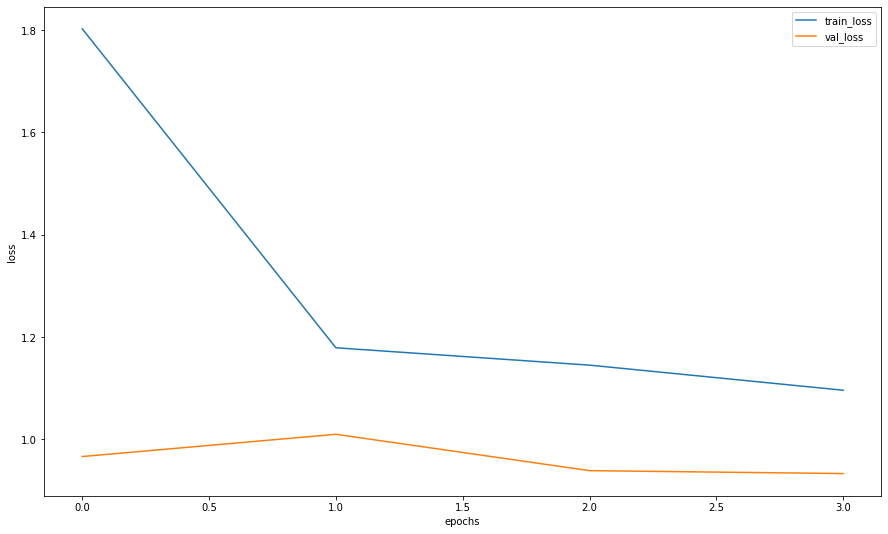

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss") 
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model2 = nn.Sequential(
    model2,  # your NN
    CRF(n_spatial_dims=2),
    CRF(n_spatial_dims=2)

)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean: tensor(-0.4509)


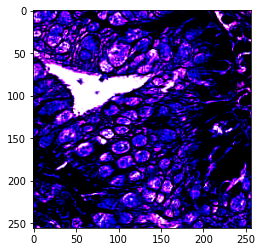

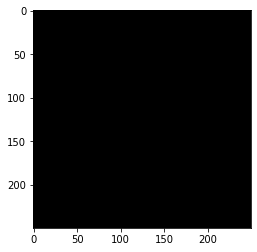

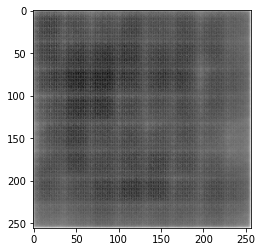

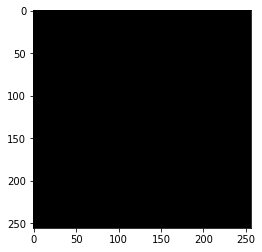

In [ ]:
import torch.nn as nn

for x, y, c in train_loader:
  x2 = x[0]
  print("mean: " + str(torch.mean(x2)))
  plt.imshow(x2.permute(1, 2, 0))
  plt.show()
  plt.imshow(y[0][0], cmap='gray')
  plt.show()
  x = x.to(DEVICE)
  res = model2(x)[0].cpu().detach()
  plt.imshow(res[0], cmap='gray')
  plt.show()
  res2 = torch.where(res[0] > 0, 1, 0)
  plt.imshow(res2, cmap='gray')
  plt.show()
  break

In [ ]:
torch.save(model.state_dict(), "model")
from google.colab import files

files.download('model')

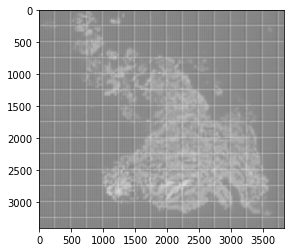

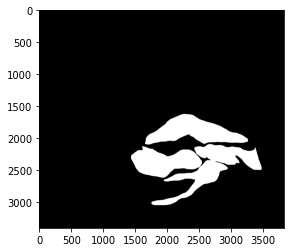

In [ ]:


cropper = ImageCropper("/content/2018_83253_1-1_2019-02-20 18_38_45-lv1-9768-30873-3832-3408.jpg")
big_squares = cropper.get_cropped_squares(250, 3)

image = np.asarray(Image.open("/content/2018_83253_1-1_2019-02-20 18_38_45-lv1-9768-30873-3832-3408_mask.jpg"))
image = np.where(image > 127, 1, 0)
h = image.shape[0]
w = image.shape[1]
res = np.ones((h, w))
cur_h = 0
cur_w = 0
siq = nn.Sigmoid()
for i1 in big_squares:
  i1 = torch.from_numpy(i1).to(DEVICE)
  i1 = torch.unsqueeze(i1, 0)
  i1 = torch.permute(i1, (0, 3, 1, 2))
  i1 = i1.float()
  i1 = model2(i1)
  i1 = i1.cpu().detach().numpy()[0, 0, 3: 253, 3:353]
  den_h = 250
  den_w = 250
  end_h = cur_h + 250
  end_w = cur_w + 250
  if (cur_h + 250) >= h:
    den_h =  (cur_h + 250) % h
    end_h = h
  if (cur_w + 250) >= w:
    den_w = (cur_w + 250) % w
    end_w = w
  res[cur_h: end_h, cur_w: end_w] = i1[0: end_h - cur_h, 0: end_w - cur_w]
  cur_w += 250
  if (cur_w) >= w:
    cur_w = 0
    cur_h += 250

plt.imshow(res, cmap='gray')
plt.show()

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
print(res)

[[-23.84659386 -15.15929794 -28.48319244 ... -16.60500336 -29.70514488
  -16.99307442]
 [-12.38460827 -20.54429817 -14.71802807 ... -19.59851265 -13.61673546
  -23.97152138]
 [-24.53795052 -16.82509995 -32.5371933  ... -18.76146889 -29.91947365
  -18.53858185]
 ...
 [-19.57279396 -23.94644165 -21.79637146 ... -23.55018997 -23.2297821
  -27.24441147]
 [-22.7756424  -18.86795425 -26.81448746 ... -23.25140762 -27.21771622
  -21.67504692]
 [-13.63965702 -15.42912483 -15.54699326 ... -14.73898506 -16.2720108
  -18.19245529]]


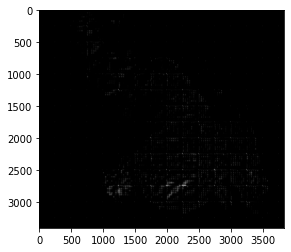

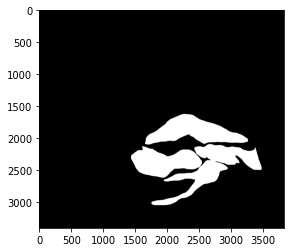

In [ ]:
res2 = np.where(res > -10, 1, 0)
plt.imshow(res2, cmap='gray')
plt.show()

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
my_file = Path("/content/data/cropped_data/img1_mask.jpg")
if my_file.is_file():
    print("Exists")
    # file exists